In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

In [2]:
# Hyperparameters
INPUT_FEATURES = 6
OUTPUT_FEATURES = 6
SEQUENCE_LENGTH = 24
HIDDEN_DIM = 64
NUM_LAYERS = 2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
# Load and preprocess the data
file_path = "/home/shreevidyag/workspace/Data_bengaluru/combined_cleaned.csv"
data = pd.read_csv(file_path)
data.head()
data.loc[:, 'PM25'] = data['PM25'].fillna(0)
data = data[24:]
data.to_csv('pollution1.csv')
dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')

In [4]:
# Ensure the data has the correct number of features
if data.shape[1] != INPUT_FEATURES:
    raise ValueError(f"Expected {INPUT_FEATURES} features, but got {data.shape[1]}.")


In [5]:
# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [6]:
# Prepare input-output sequences
def create_sequences(data, sequence_length):
    inputs, targets = [], []
    for i in range(len(data) - sequence_length):
        inputs.append(data[i:i + sequence_length, :])
        targets.append(data[i + sequence_length, :])
    return np.array(inputs), np.array(targets)

inputs, targets = create_sequences(data, SEQUENCE_LENGTH)


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

In [8]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
# Define the device (cuda if available, otherwise cpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [11]:
# Seq2Seq LSTM Model
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, future_steps=1):
        # Get the device from the input tensor
        device = x.device

        batch_size = x.size(0)

        # Encoder
        _, (hidden, cell) = self.encoder(x)

        # Prepare decoder input (initially zero)
        decoder_input = torch.zeros(batch_size, 1, self.hidden_dim).to(device)
        outputs = []

        # Decode step by step
        for _ in range(future_steps):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            step_output = self.fc(decoder_output[:, -1, :])
            outputs.append(step_output)
            decoder_input = decoder_output

        return torch.stack(outputs, dim=1)


In [12]:
# Initialize model, loss function, and optimizer
model = Seq2SeqLSTM(INPUT_FEATURES, HIDDEN_DIM, OUTPUT_FEATURES, NUM_LAYERS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
# Define the path to save/load the model
MODEL_SAVE_PATH = 'seq2seq_lstm_model.pth'  # Path to save/load the model

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Function to load the model
def load_model(model, path):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
    else:
        print(f"Model file not found at {path}, starting with a fresh model.")


In [14]:
# Training loop
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(X_batch, future_steps=1).squeeze(1)

            # Compute loss
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f}")

    # Save the model after training
    save_model(model, MODEL_SAVE_PATH)


In [15]:
# Evaluation loop
def evaluate_model():
    model.eval()
    test_loss = 0
    inv_yhat = []
    inv_y = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch, future_steps=1).squeeze(1)
            
            # Append predictions and true values to lists
            inv_yhat.append(outputs.cpu().numpy())
            inv_y.append(y_batch.cpu().numpy())

            # Compute loss
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

    # Convert lists to numpy arrays
    inv_yhat = np.concatenate(inv_yhat, axis=0)
    inv_y = np.concatenate(inv_y, axis=0)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print(f"Test RMSE: {rmse:.3f}")

    # Calculate R^2
    r2 = r2_score(inv_y, inv_yhat)
    print(f'Variance score: {r2:.2f}')

    # Pearson correlation
    corr, _ = pearsonr(inv_y.flatten(), inv_yhat.flatten())
    print(f'Pearson correlation: {corr:.3f}')

    # Plot results
    plot_predicted(inv_yhat[424:724], inv_y[424:724])


In [16]:
# Plotting function
def plot_predicted(predicted_data, true_data):
    plt.figure(figsize=(17, 8))
    plt.title('Prediction vs. Actual after 100 epochs of training')
    plt.plot(true_data, label='True Data', color='green')
    plt.plot(predicted_data, label='Prediction', color='red')
    plt.xlabel('Index')
    plt.ylabel('PM2.5 Concentration $(mu g  m^3)$')
    plt.legend()
    plt.savefig("bilstm_att_regularizer_pytorch.pdf")
    plt.show()


In [17]:
# Load the model if it exists, else train from scratch
load_model(model, MODEL_SAVE_PATH)
if not os.path.exists(MODEL_SAVE_PATH):
    train_model()

Model file not found at seq2seq_lstm_model.pth, starting with a fresh model.
Epoch 1/50, Loss: 0.0060
Epoch 2/50, Loss: 0.0046
Epoch 3/50, Loss: 0.0045
Epoch 4/50, Loss: 0.0043
Epoch 5/50, Loss: 0.0042
Epoch 6/50, Loss: 0.0041
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0039
Epoch 9/50, Loss: 0.0038
Epoch 10/50, Loss: 0.0038
Epoch 11/50, Loss: 0.0037
Epoch 12/50, Loss: 0.0036
Epoch 13/50, Loss: 0.0035
Epoch 14/50, Loss: 0.0035
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0032
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0030
Epoch 19/50, Loss: 0.0029
Epoch 20/50, Loss: 0.0028
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0026
Epoch 23/50, Loss: 0.0026
Epoch 24/50, Loss: 0.0025
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0023
Epoch 27/50, Loss: 0.0022
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0020
Epoch 31/50, Loss: 0.0019
Epoch 32/50, Loss: 0.0019
Epoch 33/50, Loss: 0.0018
Epoch 34/50, Loss: 0.0018
Epoch 35/50, Loss: 0.0017
Epoch 36/50, Loss: 0.0

Test RMSE: 0.051
Variance score: 0.78
Pearson correlation: 0.985


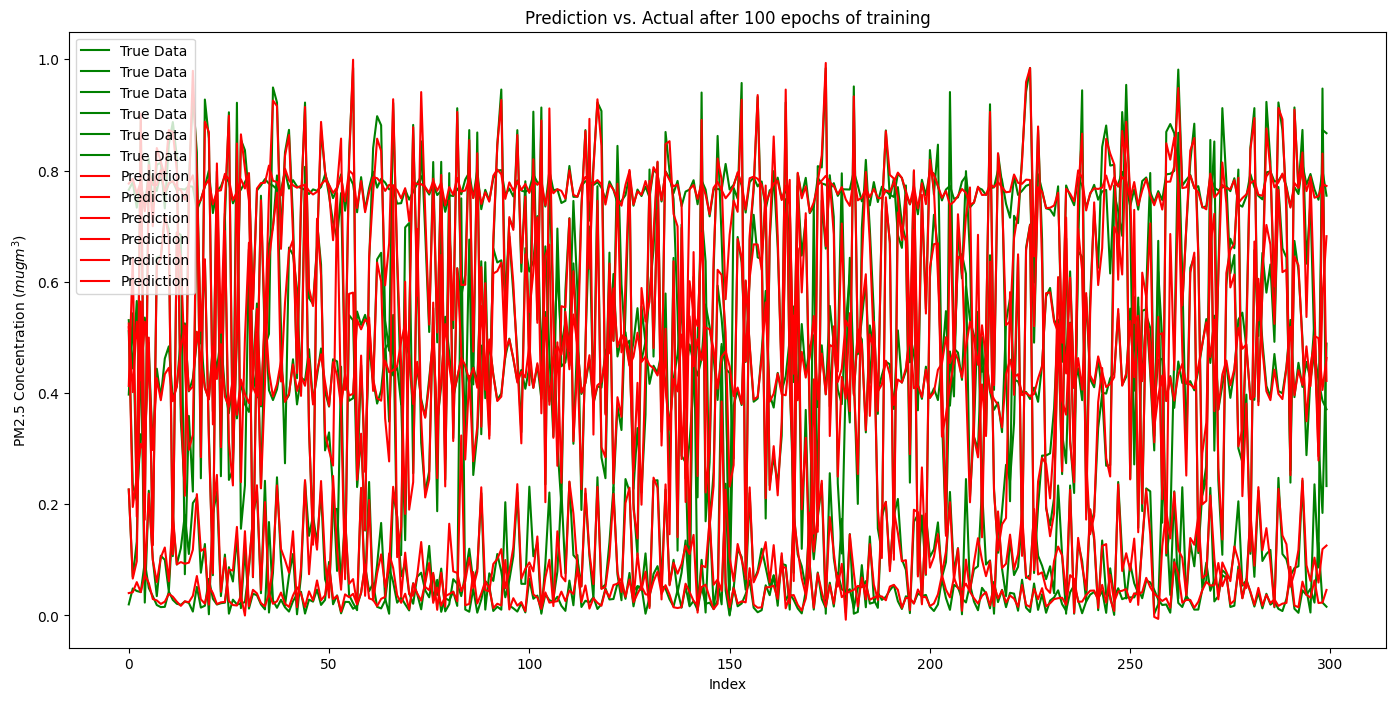

In [18]:
# Evaluate the model
evaluate_model()